In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress
import seaborn as sns

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
out_dir = os.path.join(base_dir, "output", "FIGURE")

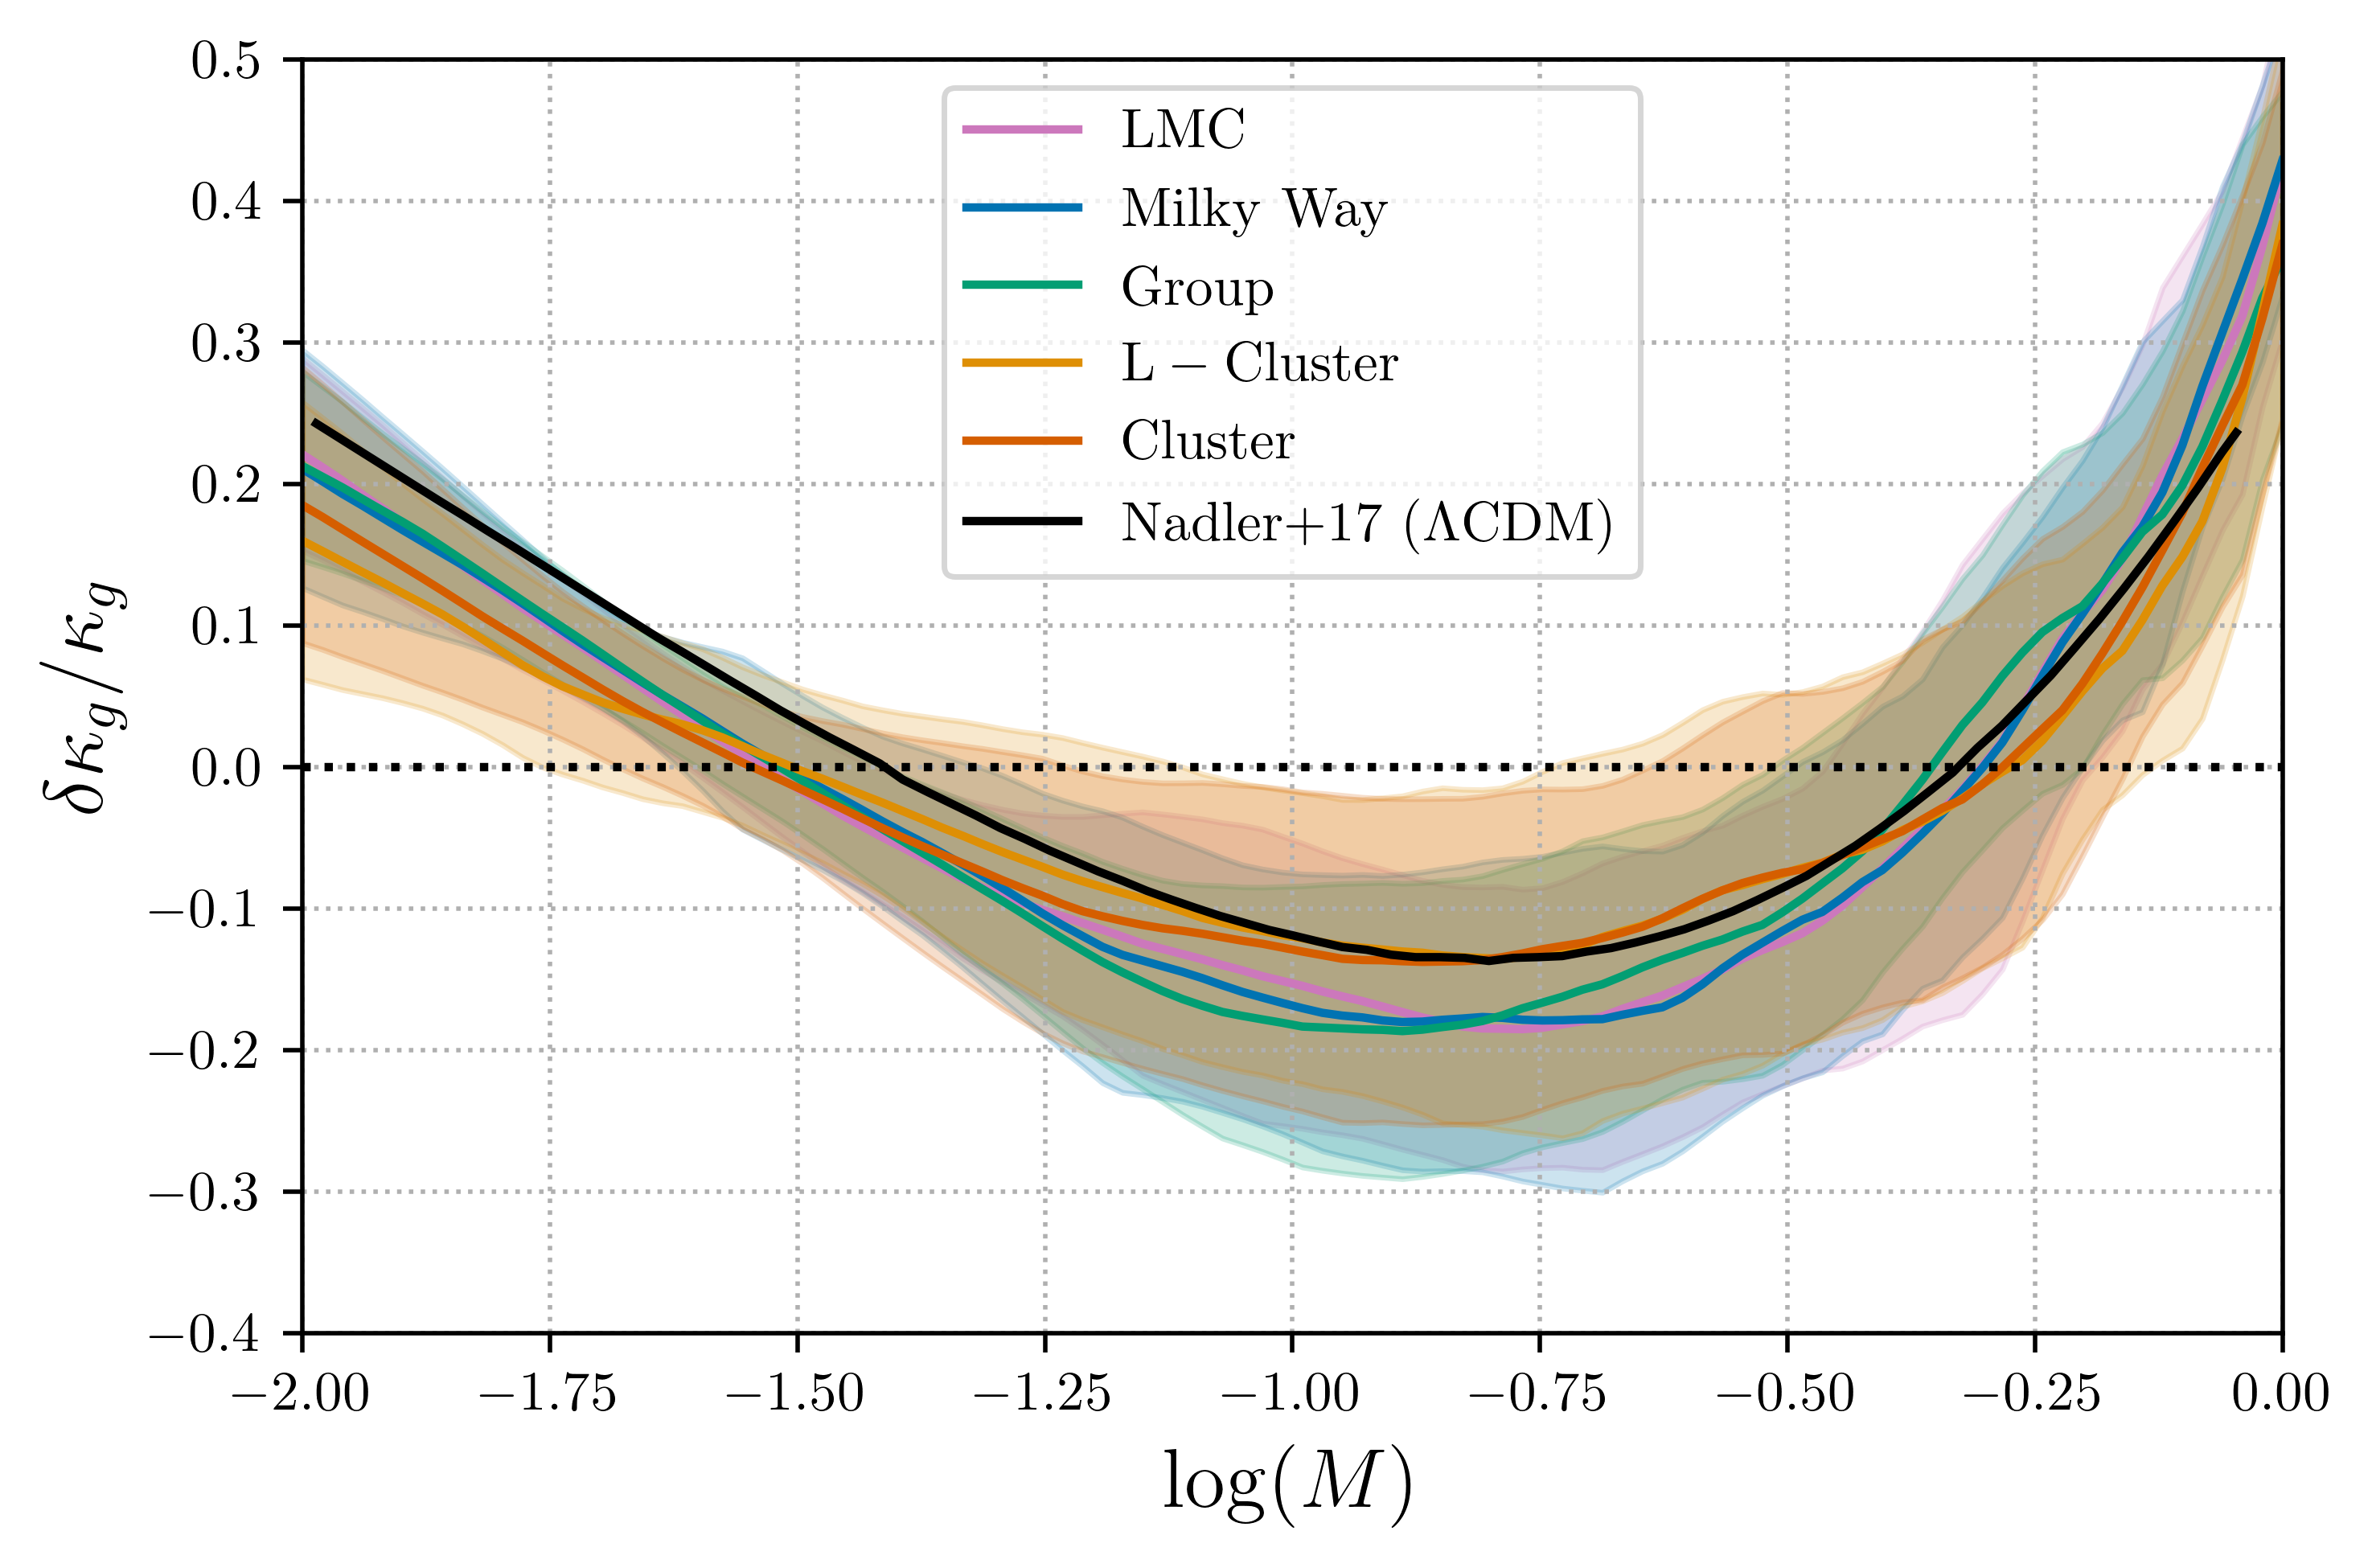

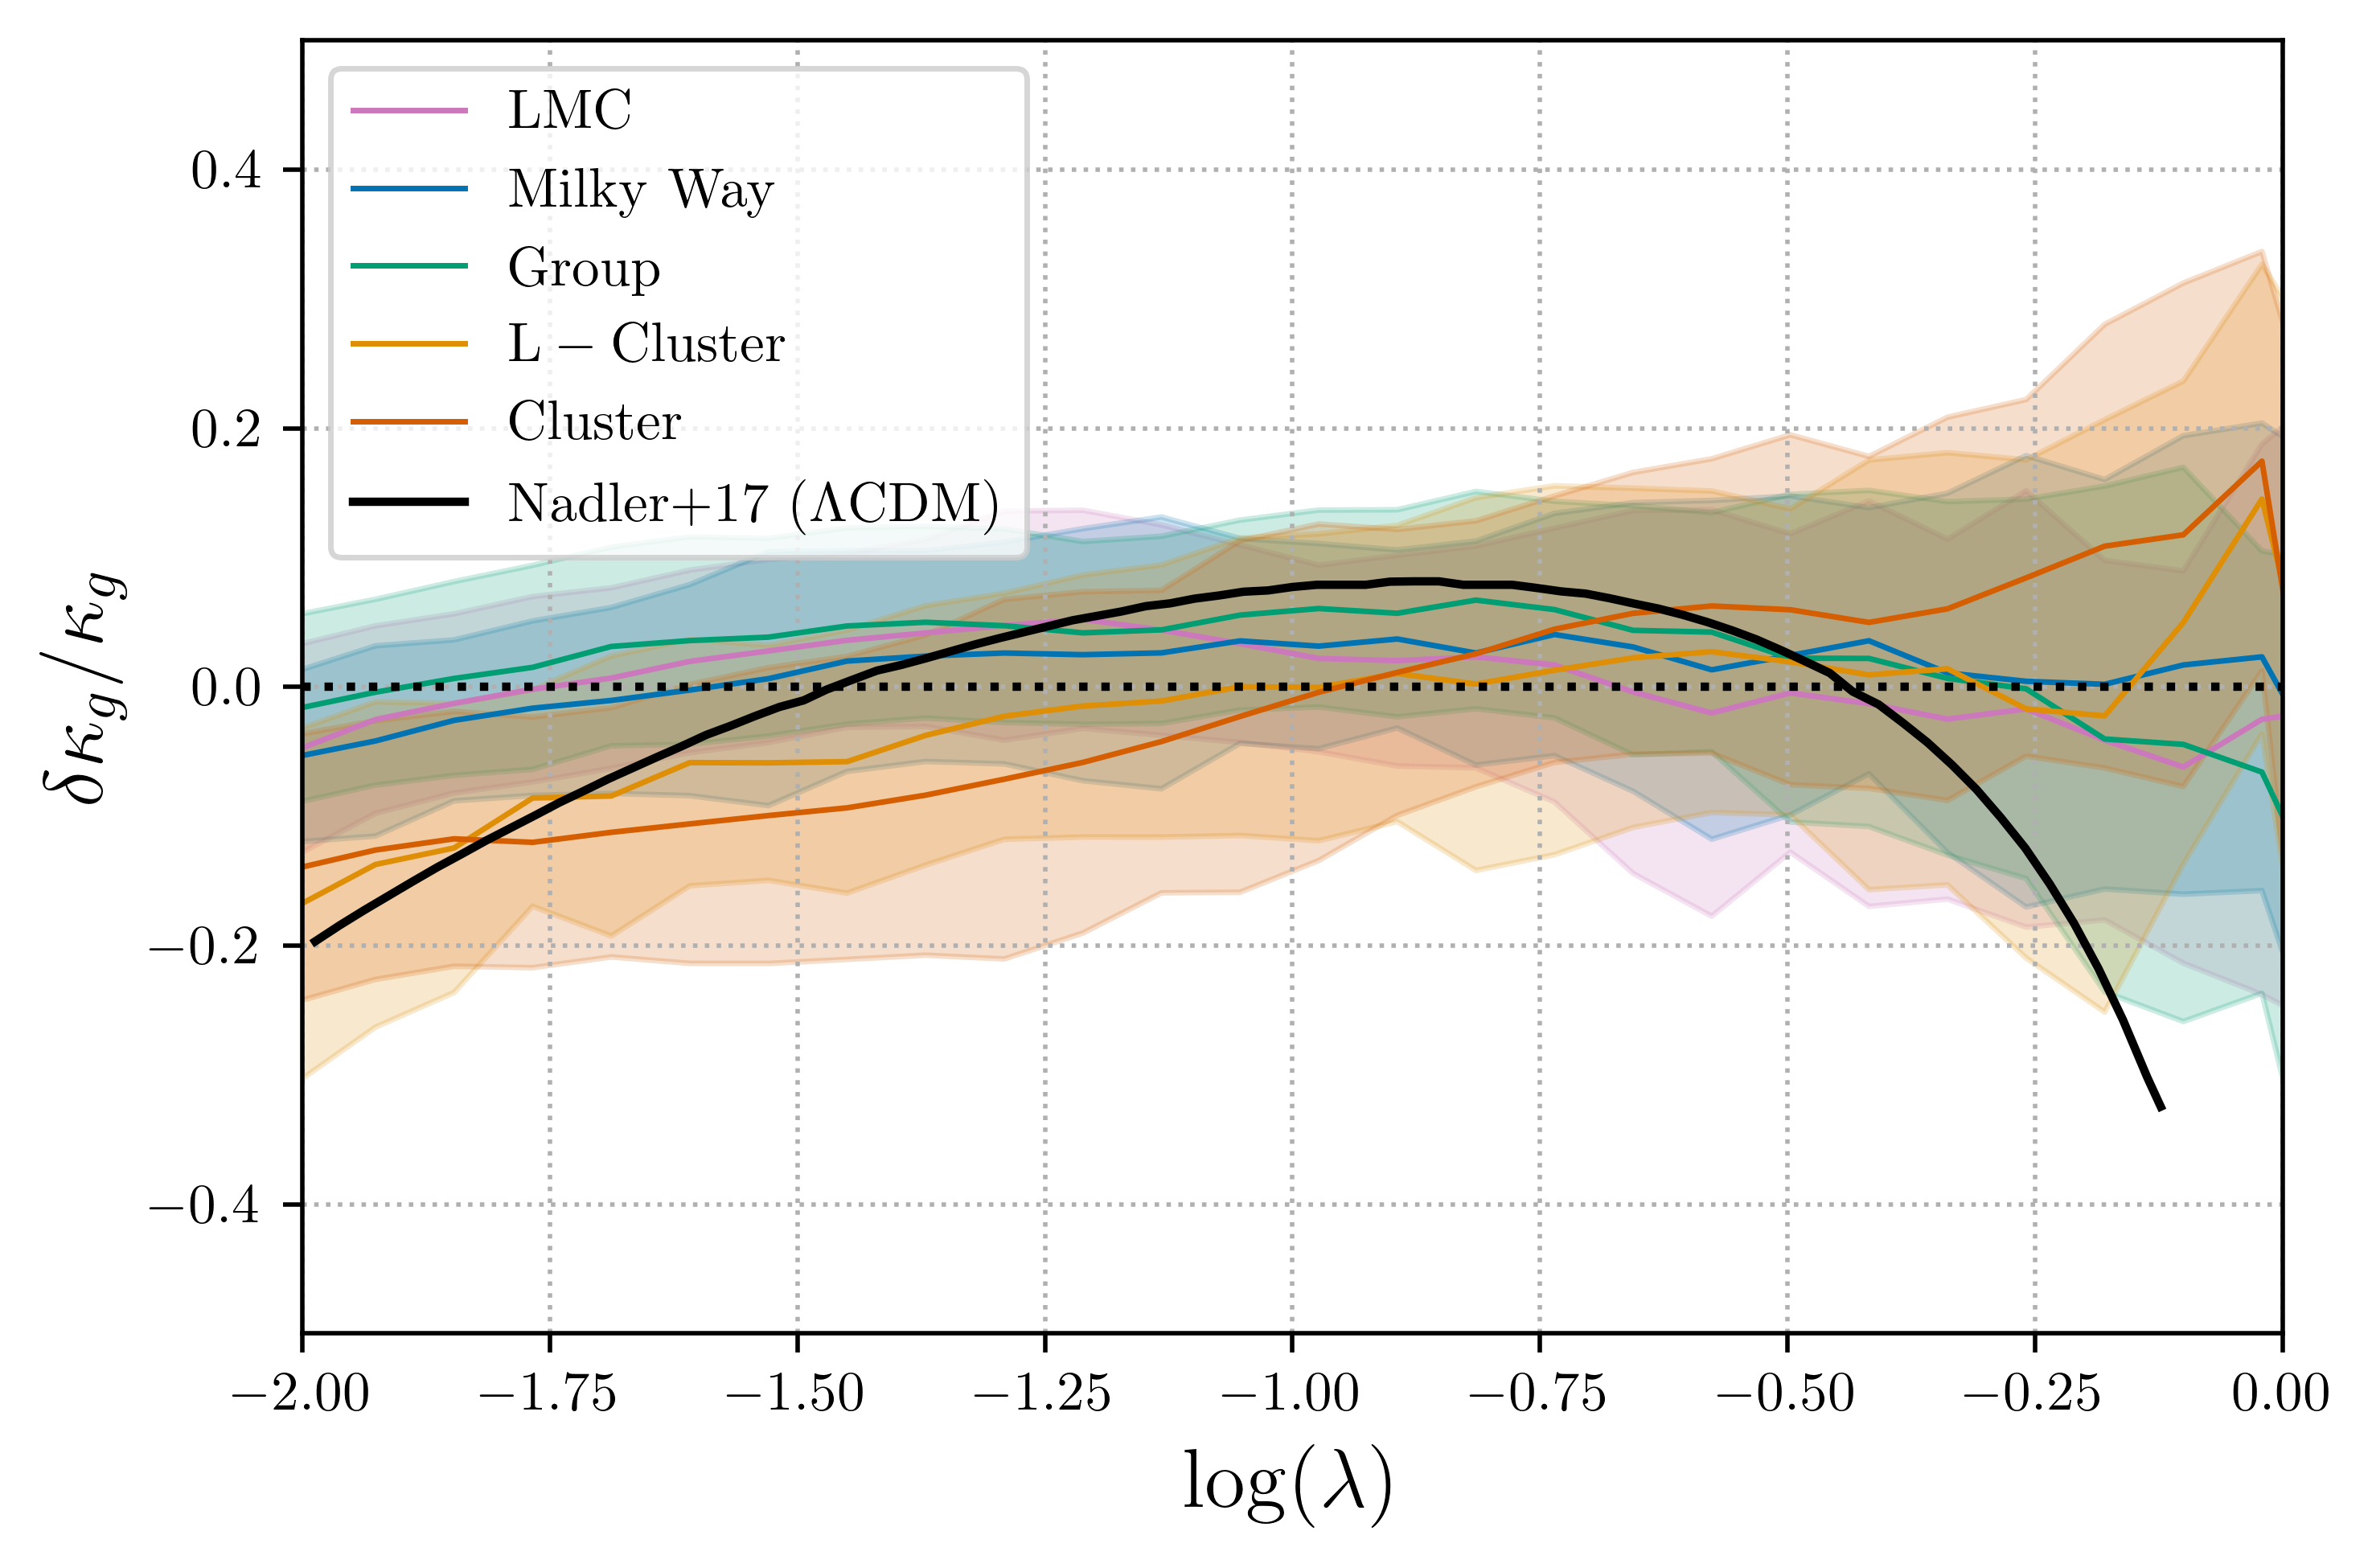

In [16]:
def plot_ppsd_residual_vs_nadler():
    logm_grid = np.linspace(-2, 0 , 100)
    m_grid = 10**logm_grid
    r_ref, log_r = None, None

    all_slopes_r, all_slopes_m = [], []

    # Read Nadler reference curves
    nadler_mass = pd.read_csv("/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure10a_blue.csv")
    nadler_radius = pd.read_csv("/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure10b_blue.csv")
    nadler_mass.columns = [c.strip() for c in nadler_mass.columns]
    nadler_radius.columns = [c.strip() for c in nadler_radius.columns]

    # --- Plot: Residual vs M ---
    plt.rcParams['text.usetex'] = True
    plt.figure(figsize=(6, 4), dpi=500)
    for i, suite in enumerate(suite_names):
        profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")

        residual_r_stack = []
        residual_m_stack = []
        slopes_r, slopes_m = [], []

        for f in sorted(f for f in os.listdir(profile_dir) if f.endswith(".csv")):
            df = pd.read_csv(os.path.join(profile_dir, f))
            r, m, Q = df['r_scaled'].values, df['m_scaled'].values, df['Q_r'].values

            if r_ref is None:
                r_ref = r
                log_r = np.log10(r_ref)

            valid_r = (Q > 0) & (r > 0)
            if np.sum(valid_r) > 5:
                logQr = np.log10(Q[valid_r])
                logR = np.log10(r[valid_r])
                slope, intercept, *_ = linregress(logR, logQr)
                slopes_r.append(slope)
                Qfit = 10**intercept * r[valid_r]**slope
                kappa = Q[valid_r]**(2/3)
                kappa_fit = Qfit**(2/3)
                residual = (kappa_fit - kappa) / kappa_fit
                interp_resid = np.interp(log_r, logR, residual, left=np.nan, right=np.nan)
                residual_r_stack.append(interp_resid)

            valid_m = (m > 0) & (Q > 0)
            if np.sum(valid_m) > 5:
                fQm = interp1d(np.log10(m[valid_m]), np.log10(Q[valid_m]),
                               bounds_error=False, fill_value=np.nan)
                logQm = fQm(logm_grid)
                Qm = 10**logQm
                valid_interp = np.isfinite(logQm)
                if np.sum(valid_interp) > 5:
                    slope, intercept, *_ = linregress(logm_grid[valid_interp], logQm[valid_interp])
                    slopes_m.append(slope)
                    Qm_fit = 10**intercept * m_grid**slope
                    kappa = Qm**(2/3)
                    kappa_fit = Qm_fit**(2/3)
                    residual = (kappa_fit - kappa) / kappa_fit
                    residual_m_stack.append(residual)

        # Suite-wise stack
        residual_r_stack = np.array(residual_r_stack)
        residual_m_stack = np.array(residual_m_stack)

        residual_r = np.nanmean(residual_r_stack, axis=0)
        residual_r_std = np.nanstd(residual_r_stack, axis=0)
        residual_m = np.nanmean(residual_m_stack, axis=0)
        residual_m_std = np.nanstd(residual_m_stack, axis=0)

        # Save slopes
        all_slopes_r += slopes_r
        all_slopes_m += slopes_m

        # Plot (vs M)
        color = sim_colors[suite]
        plt.plot(logm_grid, residual_m, lw=1.5, label=rf"$\mathrm{{{sim_names[suite]}}}$", color=color)
        plt.fill_between(logm_grid, residual_m - residual_m_std, residual_m + residual_m_std,
                         color=color, alpha=0.2)
    plt.plot(nadler_mass['x'], nadler_mass['y'], label=r'$\mathrm{Nadler{+}17\ (}\Lambda\mathrm{CDM)}$', color='black', lw=1.5)
    plt.axhline(0, color='k', linestyle=':')
    plt.xlabel(r'$\log(M)$', fontsize=15)
    plt.ylabel(r'$\delta \kappa_g / \kappa_g$', fontsize=15)
    plt.xlim(-2,0)
    plt.ylim(-0.4, 0.5)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which="major", linestyle=":")
    plt.savefig(os.path.join(out_dir, "entropy_residual_m_Nadler.pdf"))
    plt.show()

    # --- Plot: Residual vs r ---
    plt.figure(figsize=(6, 4), dpi=500)   

    for i, suite in enumerate(suite_names):
        profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")

        residual_r_stack = []

        for f in sorted(f for f in os.listdir(profile_dir) if f.endswith(".csv")):
            df = pd.read_csv(os.path.join(profile_dir, f))
            r, Q = df['r_scaled'].values, df['Q_r'].values

            valid = (Q > 0) & (r > 0)
            if np.sum(valid) > 5:
                logQr = np.log10(Q[valid])
                logR = np.log10(r[valid])
                slope, intercept, *_ = linregress(logR, logQr)
                Qfit = 10**intercept * r[valid]**slope
                kappa = Q[valid]**(2/3)
                kappa_fit = Qfit**(2/3)
                residual = (kappa_fit - kappa) / kappa_fit
                interp_resid = np.interp(log_r, logR, residual, left=np.nan, right=np.nan)
                residual_r_stack.append(interp_resid)

        residual_r_stack = np.array(residual_r_stack)
        residual_r = np.nanmean(residual_r_stack, axis=0)
        residual_r_std = np.nanstd(residual_r_stack, axis=0)

        color = sim_colors[suite]
        plt.plot(log_r, residual_r, label=rf"$\mathrm{{{sim_names[suite]}}}$", lw=1, color=color)
        plt.fill_between(log_r, residual_r - residual_r_std, residual_r + residual_r_std,
                         color=color, alpha=0.2)
        
    plt.plot(nadler_radius['x'], nadler_radius['y'], label=r'$\mathrm{Nadler{+}17\ (}\Lambda\mathrm{CDM)}$', color='black', lw=1.5)
    plt.axhline(0, color='k', linestyle=':')
    plt.xlabel(r'$\log(\lambda)$', fontsize=15)
    plt.ylabel(r'$\delta \kappa_g / \kappa_g$', fontsize=15)
    plt.xlim(-2,0)
    plt.ylim(-0.5, 0.5)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which="major", linestyle=":")
    plt.savefig(os.path.join(out_dir, "entropy_residual_r_Nadler.pdf"))
    plt.show()

plot_ppsd_residual_vs_nadler()

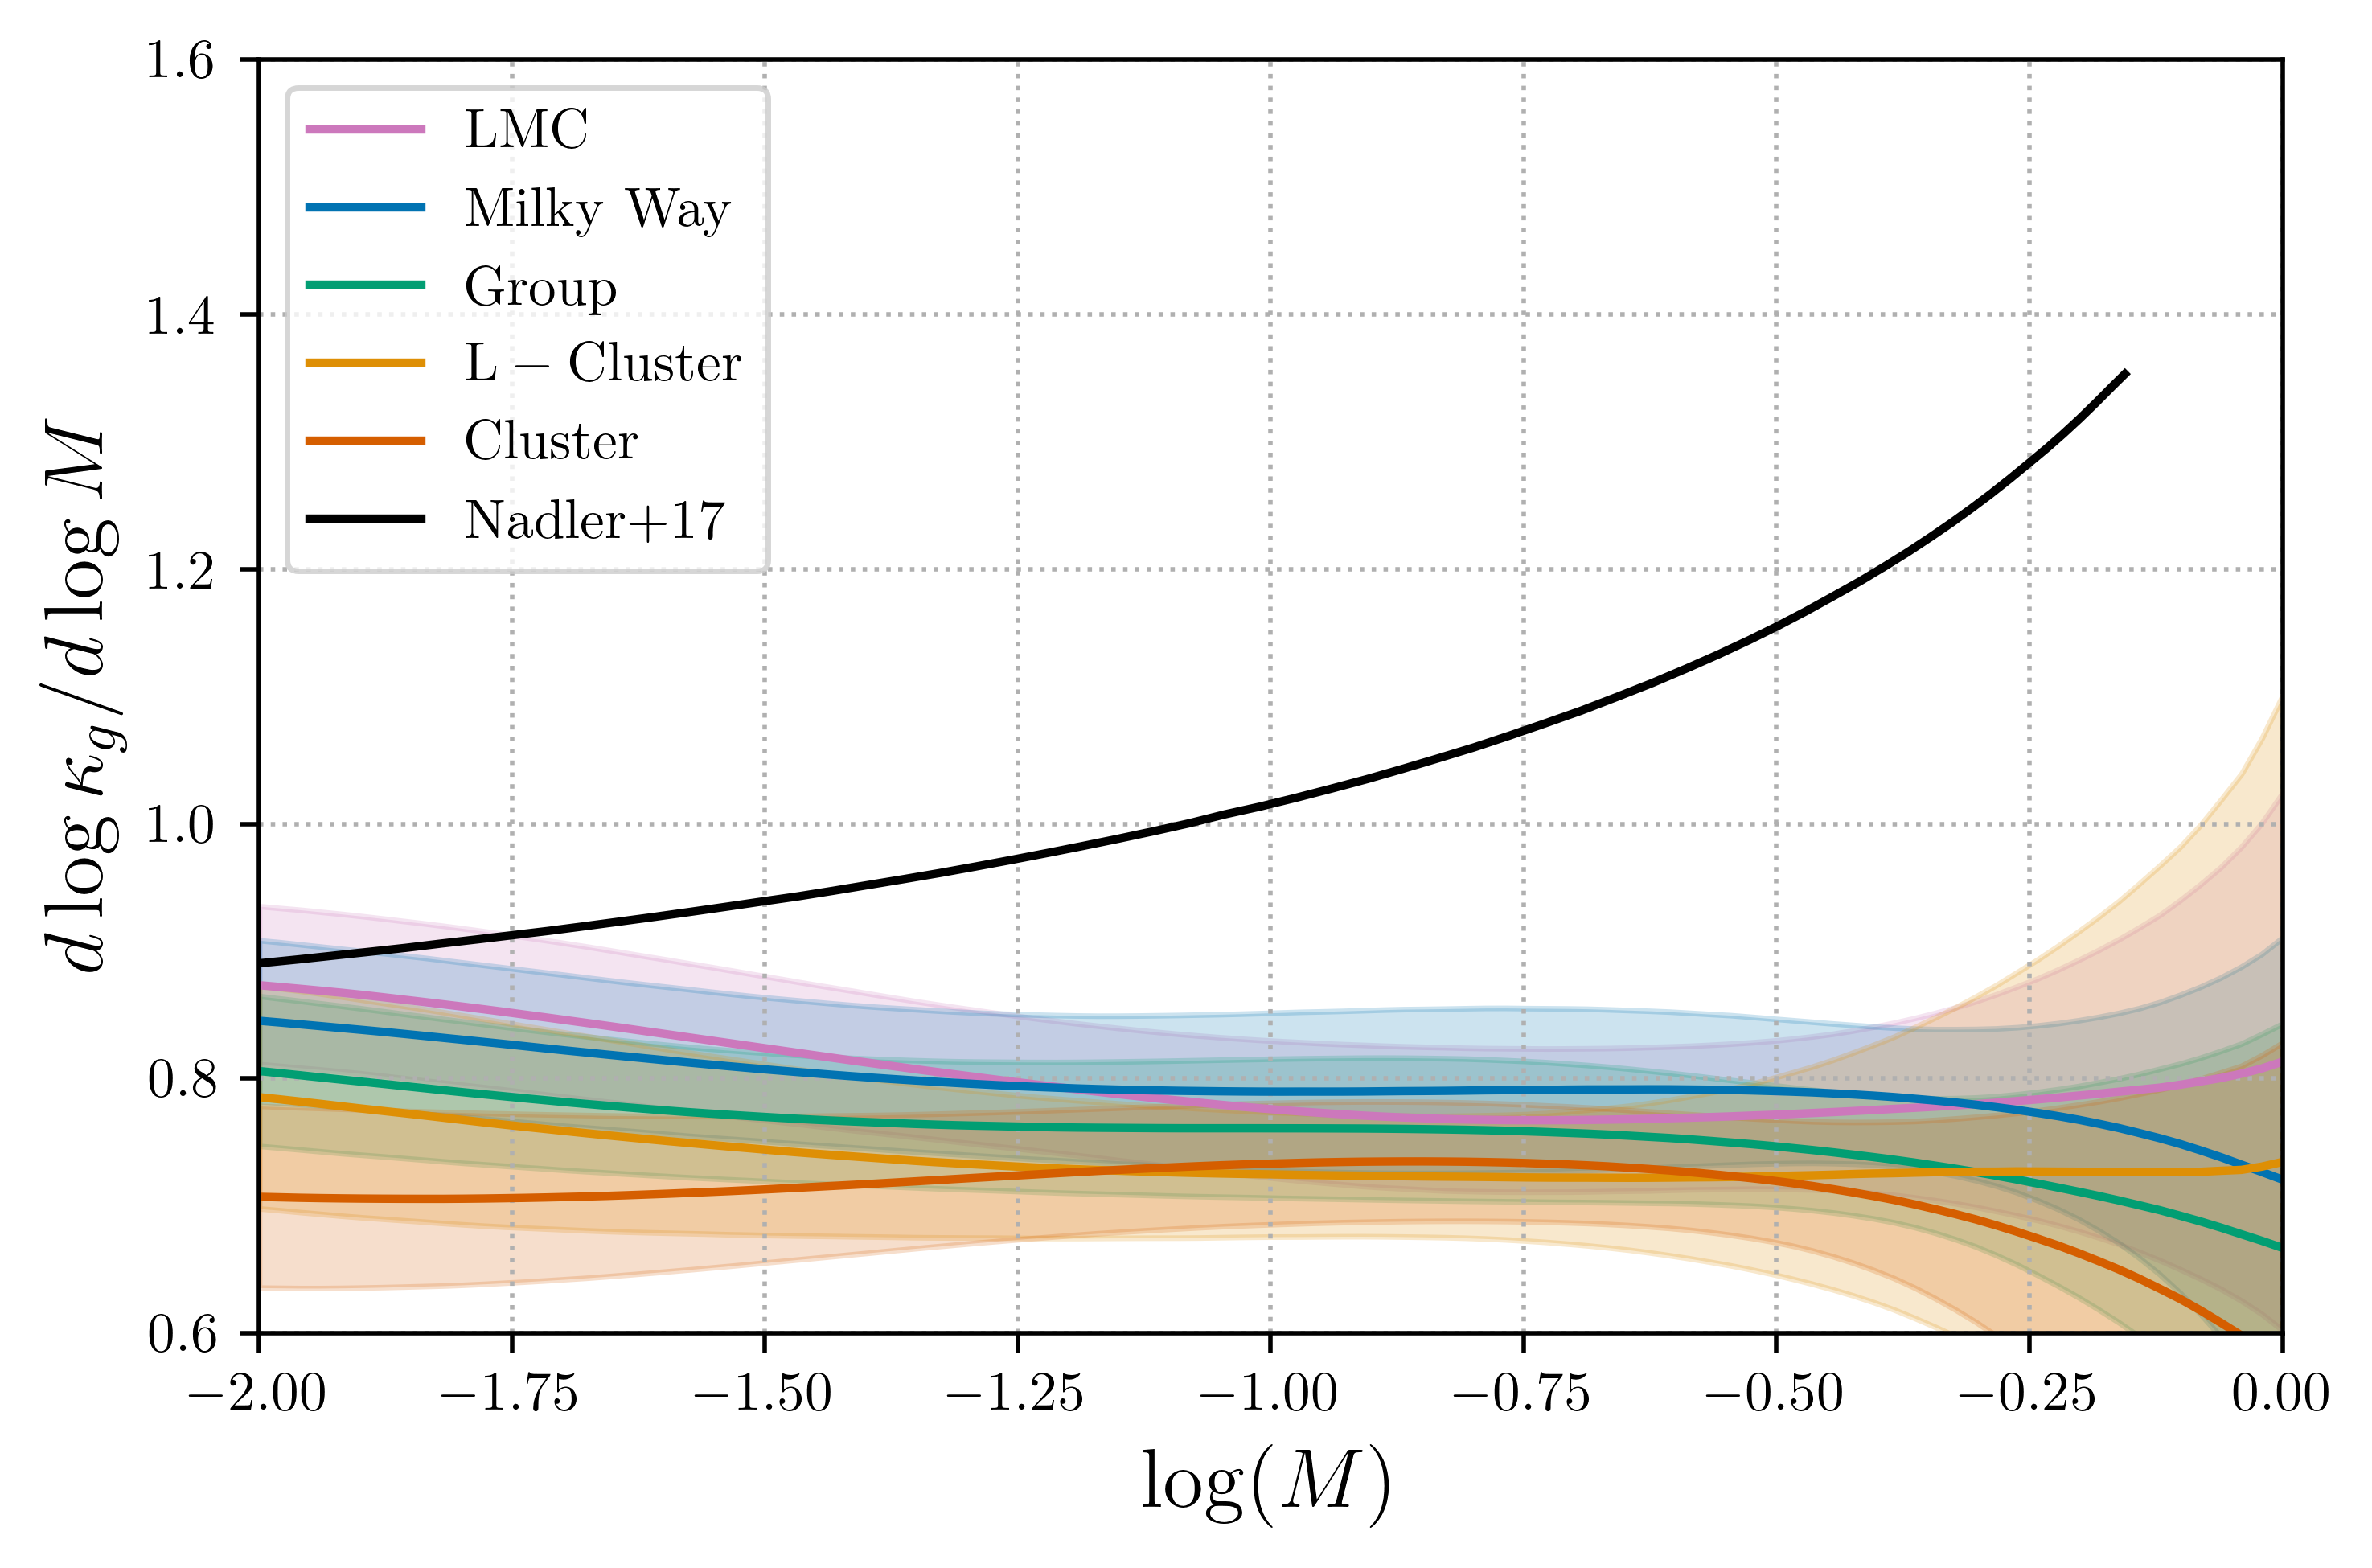

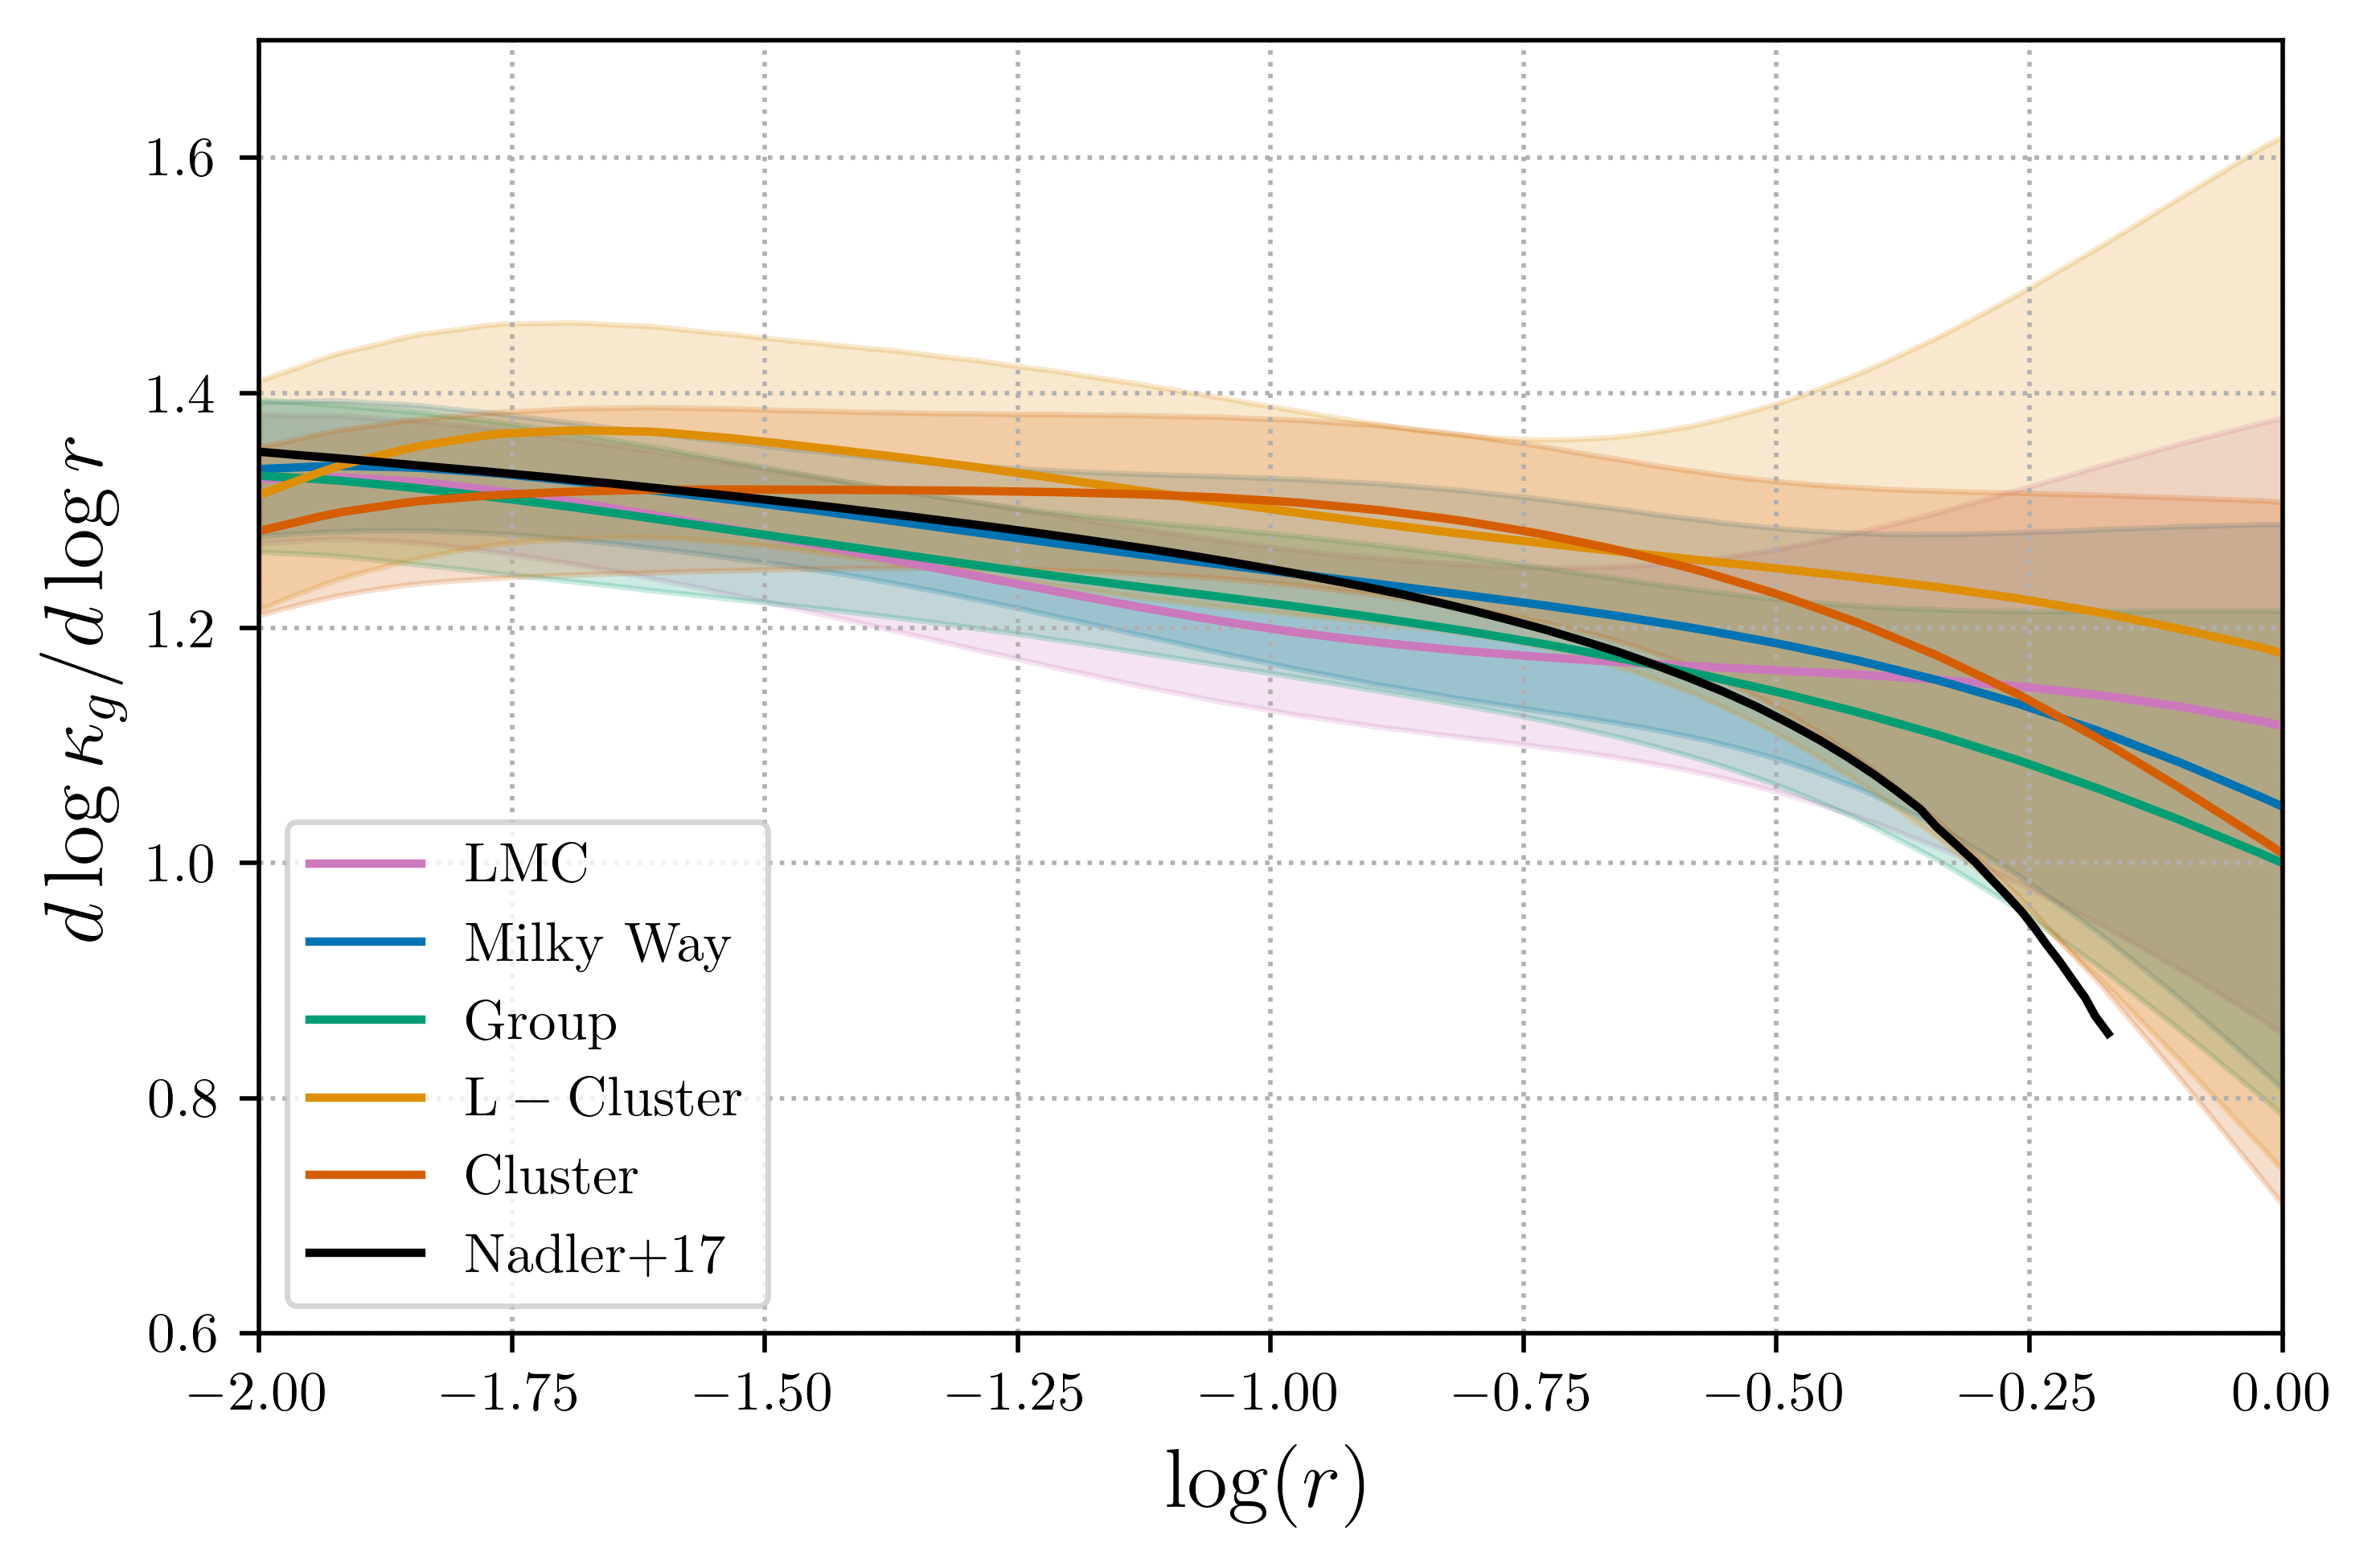

In [13]:
def plot_entropy_slope_from_precomputed():
    logm_grid = np.linspace(-2, 0, 100)
    logr_grid = np.linspace(-2, 0, 100)

    # Load Nadler reference slope curves (entropy)
    nadler_slope_m = pd.read_csv("/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure7a_blue.csv")
    nadler_slope_r = pd.read_csv("/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure8a_blue.csv")
    nadler_slope_m.columns = [c.strip() for c in nadler_slope_m.columns]
    nadler_slope_r.columns = [c.strip() for c in nadler_slope_r.columns]

    # --- Entropy slope vs log(M) ---
    plt.rcParams['text.usetex'] = True
    plt.figure(figsize=(6, 4), dpi=500)

    for suite in suite_names:
        slope_m_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_m")
        interp_stack = []

        for f in sorted(os.listdir(slope_m_dir)):
            if not f.endswith(".csv"):
                continue
            df = pd.read_csv(os.path.join(slope_m_dir, f))
            m = df["m_scaled"].values
            slope_q = df["slope_Q_r"].values
            valid = (m > 0) & np.isfinite(slope_q)
            if np.sum(valid) < 5:
                continue
            logm = np.log10(m[valid])
            slope_kappa = -2/3 * slope_q[valid]
            f_interp = interp1d(logm, slope_kappa, bounds_error=False, fill_value=np.nan)
            interp_stack.append(f_interp(logm_grid))

        if len(interp_stack) == 0:
            continue

        interp_stack = np.array(interp_stack)
        slope_mean = np.nanmean(interp_stack, axis=0)
        slope_std = np.nanstd(interp_stack, axis=0)

        color = sim_colors[suite]
        plt.plot(logm_grid, slope_mean, lw=1.5, label=rf"$\mathrm{{{sim_names[suite]}}}$", color=color)
        plt.fill_between(logm_grid, slope_mean - slope_std, slope_mean + slope_std, color=color, alpha=0.2)

    plt.plot(nadler_slope_m['x'], nadler_slope_m['y'], label=r'$\mathrm{Nadler{+}17}$', color='black', lw=1.5)
    plt.xlabel(r'$\log(M)$', fontsize=15)
    plt.ylabel(r'$d\log \kappa_g / d\log M$', fontsize=15)
    plt.xlim(-2, 0)
    plt.ylim(0.6, 1.6)
    plt.grid(True, which="major", linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "entropy_slope_m_Nadler.pdf"))
    plt.show()

    # --- Entropy slope vs log(r) ---
    plt.figure(figsize=(6, 4), dpi=500)

    for suite in suite_names:
        slope_r_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        interp_stack = []

        for f in sorted(os.listdir(slope_r_dir)):
            if not f.endswith(".csv"):
                continue
            df = pd.read_csv(os.path.join(slope_r_dir, f))
            r = df["r_scaled"].values
            slope_q = df["slope_Q_r"].values
            valid = (r > 0) & np.isfinite(slope_q)
            if np.sum(valid) < 5:
                continue
            logr = np.log10(r[valid])
            slope_kappa = -2/3 * slope_q[valid]
            f_interp = interp1d(logr, slope_kappa, bounds_error=False, fill_value=np.nan)
            interp_stack.append(f_interp(logr_grid))

        if len(interp_stack) == 0:
            continue

        interp_stack = np.array(interp_stack)
        slope_mean = np.nanmean(interp_stack, axis=0)
        slope_std = np.nanstd(interp_stack, axis=0)

        color = sim_colors[suite]
        plt.plot(logr_grid, slope_mean, lw=1.5, label=rf"$\mathrm{{{sim_names[suite]}}}$", color=color)
        plt.fill_between(logr_grid, slope_mean - slope_std, slope_mean + slope_std, color=color, alpha=0.2)

    plt.plot(nadler_slope_r['x'], nadler_slope_r['y'], label=r'$\mathrm{Nadler{+}17}$', color='black', lw=1.5)
    plt.xlabel(r'$\log(r)$', fontsize=15)
    plt.ylabel(r'$d\log \kappa_g / d\log r$', fontsize=15)
    plt.xlim(-2, 0)
    plt.ylim(0.6, 1.7)
    plt.grid(True, which="major", linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "entropy_slope_r_Nadler.pdf"))
    plt.show()

plot_entropy_slope_from_precomputed()